# Deep Recurrent Neural Networks

Up to now, we only discussed recurrent neural networks with a single unidirectional hidden layer. In it the
specific functional form of how latent variables and observations interact was rather arbitrary. This isn’t
a big problem as long as we have enough flexibility to model different types of interactions. With a single
layer, however, this can be quite challenging. In the case of the perceptron we fixed this problem by adding
more layers. Within RNNs this is a bit more tricky, since we first need to decide how and where to add extra
nonlinearity. Our discussion below focuses primarily on LSTMs but it applies to other sequence models, too.
   
   • We could add extra nonlinearity to the gating mechansims. That is, instead of using a single perceptron
     we could use multiple layers. This leaves the mechanism of the LSTM unchanged. Instead it makes
     it more sophisticated. This would make sense if we were led to believe that the LSTM mechanism
     describes some form of universal truth of how latent variable autoregressive models work.
   
   • We could stack multiple layers of LSTMs on top of each other. This results in a mechanism that is
     more flexible, due to the combination of several simple layers. In particular, data might be relevant
     at different levels of the stack. For instance, we might want to keep high-level data about financial
     market conditions (bear or bull market) available at a high level, whereas at a lower level we only
     record shorter-term temporal dynamics.
    
Beyond all this abstract discussion it is probably easiest to understand the family of models we are interested
in by reviewing the diagram below. It describes a deep recurrent neural network with L hidden layers. Each
hidden state is continuously passed to the next time step of the current layer and the next layer of the current
time step.

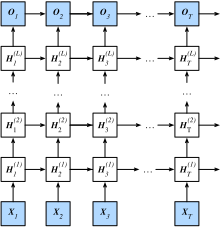

In [1]:
from IPython.display import SVG
SVG('img/deep-rnn.svg')

## Functional Dependencies 

At time step t we assume that we have a minibatch $X_t ∈ R^{n×d}$ (number of examples: $n$, number of inputs:
$d$). The hidden state of hidden layer $l (l = 1, . . . , T )$ is $H_t^{(l)} ∈ R^{n×h}$ (number of hidden units: $h$), the output
layer variable is $O_t ∈ R^{(n×q)}$
(number of outputs: $q$) and a hidden layer activation function $f_l$ for layer $l$. We
compute the hidden state of layer 1 as before, using $X_t$ as input. For all subsequent layers the hidden state
of the previous layer is used in its place.
$$H_t^{(1)} = f_1(X_t , H_{t−1}^{(1)})$$
$$H_t^{(1)} = f_1(H_{t}^{(1-1)} , H_{t−1}^{(1)})$$
Finally, the output of the output layer is only based on the hidden state of hidden layer $L$. We use the
output function $g$ to address this:
$$O_t = g(H_t^{(L)})$$
Just as with multilayer perceptrons, the number of hidden layers $L$ and number of hidden units $h$ are hyper
parameters. In particular, we can pick a regular RNN, a GRU or an LSTM to implement the model.

## Concise Implementation 

Fortunately many of the logistical details required to implement multiple layers of an RNN are readily avail-
able in Gluon. To keep things simple we only illustrate the implementation using such built-in functionality.
The code is very similar to the one we used previously for LSTMs. In fact, the only difference is that
we specify the number of layers explicitly rather than picking the default of a single layer. Let’s begin by
importing the appropriate modules and data.

In [5]:
import sys
sys.path.insert(0, '..')

import d2l
import torch
import torch.nn as nn
from d2l import RNNModel 
from d2l import load_data_time_machine
from d2l import train_and_predict_rnn_nn
torch.set_default_tensor_type('torch.cuda.FloatTensor')

corpus_indices, vocab = load_data_time_machine()

The architectural decisions (parameters, etc.) are very similar to those of previous sections. We pick the
same number of inputs and outputs as we have distinct tokens, i.e. vocab_size. The number of hidden
units is still 256 and we retain a learning rate of 100. The only difference is that we now select a nontrivial
number of layers num_layers = 2. Since the model is somewhat slower to train we use 3000 iterations.

In [6]:
num_inputs, num_hiddens, num_layers, num_outputs = len(vocab), 256, 2, len(vocab)
ctx = d2l.try_gpu()
num_epochs, num_steps, batch_size, lr, clipping_theta = 500, 35, 32, 5, 1
prefixes = ['traveller', 'time traveller']
print('Using', ctx)

Using cuda:0


## Training 

The actual invocation logic is identical to before and we re-use train_and_predict_rnn_gluon. The only
difference is that we now instantiate two layers with LSTMs. This rather more complex architecture and
the large number of epochs slow down training considerably.

In [8]:
def init_lstm_state(batch_size, num_hiddens, device):
    return  (torch.zeros(size=(batch_size, num_hiddens), device=device),
             torch.zeros(size=(batch_size, num_hiddens), device=device))

In [11]:
lstm_layer = nn.LSTM(input_size=num_inputs, hidden_size=num_hiddens)
model = RNNModel(lstm_layer, num_hiddens, len(vocab))
model.to(ctx)
train_and_predict_rnn_nn(model, num_hiddens, init_lstm_state, corpus_indices, vocab,
                         ctx, num_epochs, num_steps, lr,
                         clipping_theta, batch_size, prefixes, 2)

epoch 125, perplexity 1.837382, time 46.93 sec
epoch 250, perplexity 1.044730, time 47.20 sec
 - traveller smiled. 'are you sure we can move freely in space
 - time traveller smiled. 'are you sure we can move freely in space
epoch 375, perplexity 1.034328, time 47.27 sec
epoch 500, perplexity 1.029750, time 59.48 sec
 - traveller smiled. 'are you sure we can move freely in space
 - time traveller smiled. 'are you sure we can move freely in space


## Heading 

• In deep recurrent neural networks, hidden state information is passed to the next time step of the
current layer and the next layer of the current time step.

• There exist many different flavors of deep RNNs, such as LSTMs, GRUs or regular RNNs. Conveniently
these models are all available as parts of the rnn module in Gluon.

• Initialization of the models requires care. Overall, deep RNNs require considerable amount of work
(learning rate, clipping, etc) to ensure proper convergence.

## Heading 

1. Try to implement a two-layer RNN from scratch using the single layer implementation we discussed in
Section 10.5.
2. Replace the LSTM by a GRU and compare the accuracy.
3. Increase the training data to include multiple books. How low can you go on the perplexity scale?
4. Would you want to combine sources of different authors when modeling text? Why is this a good idea?
What could go wrong?